In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [6]:
df_ratings=df.pivot(index='movieId',columns='userId',values='rating')
df_ratings.fillna(0,inplace=True)

In [7]:
dfflagtrain=df.pivot(index='movieId',columns='userId',values='dstype_random_train')
dfflagtrain.head()
dfflagtrain.fillna(0,inplace=True)
df_train=df_ratings*dfflagtrain

In [8]:
dfflagvalid=df.pivot(index='movieId',columns='userId',values='dstype_random_valid')
dfflagvalid.head()
dfflagvalid.fillna(0,inplace=True)
df_valid=df_ratings*dfflagvalid

## Dataset and DataLoader

In [9]:
class autoencdata (Dataset):
    def __init__(self,dfX):
        self.dfX=dfX
        
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values)

In [10]:
dstrain=autoencdata(df_train)
dsvalid=autoencdata(df_valid)

In [17]:
bs=64

In [18]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=True)
dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [19]:
df['rating'].min(),df['rating'].max()

(0.5, 5.0)

In [20]:
df_train.shape

(9724, 610)

In [21]:
len(dltrain),len(dlvalid)

(152, 152)

## Create the Model Architecture for the Encoder

In [24]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [25]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return decoded,loss

In [26]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0,0,0])

In [27]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=50, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [28]:
for Xb in dltrain:
    print (Xb)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [29]:
Xb.size()

torch.Size([64, 610])

In [30]:
Xb.squeeze(0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [31]:
preds,loss=autoenc.forward(Xb)

In [32]:
loss.backward()

In [33]:
preds.size()

torch.Size([64, 50])

In [34]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [35]:
device="cuda:0"

In [36]:
wd=1e-4
#wd=1e-1

In [37]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [38]:
len(dltrain),len(dlvalid)

(152, 152)

In [39]:
import matplotlib.pyplot as plt

In [40]:
dltrain.batch_size

64

In [41]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb in iterator:
            Xb=Xb.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [42]:
autoenc=autoencoder(df_train.shape[1],[20,10],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [43]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.6)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
  )
  (fc): Linear(in_features=20, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [44]:
len(dltrain)

152

In [45]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

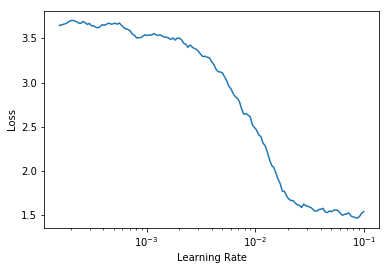

In [46]:
learner.plot_lrs(10)

In [49]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.25,0.25,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=3e-2,end_lr=5e-4)

In [50]:
learner.run_epochs(dltrain,dlvalid,31)

Epoch:0 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.1851178407669067  Valid Loss:1.0310707092285156 
Epoch:1 Learning rate 0.0038729833462074164 Weight Decay 1e-07 Train Loss:1.003689169883728  Valid Loss:0.9441735148429871 
Epoch:2 Learning rate 0.0004999999999999999 Weight Decay 1e-07 Train Loss:0.9867559671401978  Valid Loss:0.9520727396011353 
Epoch:3 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.0897201299667358  Valid Loss:0.9591107964515686 
Epoch:4 Learning rate 0.010779123358892525 Weight Decay 1e-07 Train Loss:0.9829736351966858  Valid Loss:0.9768510460853577 
Epoch:5 Learning rate 0.003872983346207416 Weight Decay 1e-07 Train Loss:0.948708176612854  Valid Loss:0.9342473745346069 
Epoch:6 Learning rate 0.0013915788418568699 Weight Decay 1e-07 Train Loss:0.9373030662536621  Valid Loss:0.9225978851318359 
Epoch:7 Learning rate 0.0004999999999999998 Weight Decay 1e-07 Train Loss:0.9346903562545776  Valid Loss:0.9241189360618591 
Epoch:8 Learning rate 0.03 Weight Deca

In [51]:
len(dltrain)

152

In [52]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([50, 610])

In [53]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 50])

In [54]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [55]:
import pickle
pickle.dump([item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))